## Learning Objectives 

* Develop a function: if a block of code will be re-used several times, develop it as a function to avoid coding errors.
* ROC/AUC
* VARImp
* Train and test your model with a small dataset.
* Model with the entire dataset when there is no error.
* Keep your notebook clean and readable.
* GLM
* See this [H2o GLM tutorial](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html), [this one](http://docs.h2o.ai/h2o-tutorials/latest-stable/tutorials/glm/glm.html) or [this one](https://h2o-release.s3.amazonaws.com/h2o/master/3252/docs-website/h2o-docs/booklets/GLM_Vignette.pdf)

In [2]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("loan_default.csv")

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     data, test_size=0.30, random_state=42)

In [5]:
train.shape

(56000, 89)

In [6]:
train.dtypes

Unnamed: 0        int64
Unnamed: 0.1      int64
id                int64
loan_default      int64
AP001             int64
                 ...   
CD170           float64
CD172           float64
CD173           float64
MB005           float64
MB007            object
Length: 89, dtype: object

In [44]:
var = pd.DataFrame(train.dtypes)
var.head(10)

,0
Unnamed: 0,int64
Unnamed: 0.1,int64
Unnamed: 0.1.1,int64
id,int64
loan_default,int64
AP001,int64
AP002,int64
AP003,int64
AP004,int64
AP005,object


In [7]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [8]:
var.columns = ['varname','dtype'] 
var.head(10)

,varname,dtype
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [9]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0,int64,Un
1,Unnamed: 0.1,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [10]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
MB     2
Un     2
lo     1
id     1
Name: source, dtype: int64

In [11]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [12]:
train['loan_default'].value_counts(dropna=False)

0    45180
1    10820
Name: loan_default, dtype: int64

# H2O

* If you encounter errors, [this page](https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/index.html) may help.

In [13]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,14 days 10 hours 22 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_jjzhang_rqihyg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,510.9 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [14]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [15]:
target='loan_default'

### Sampling with 10%

In [16]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [17]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [57]:
glm_v1 = H2OGeneralizedLinearEstimator(family= "binomial", lambda_ = 0.01) #, compute_p_values = True)
glm_v1.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |███████████████████████████████████████████████| 100%


When I used lambda level of .05, the model was very weak, very little features to select from, the cum lyft level is very low as well as the precision and AUC.

Using the lambda level of .01 to have more regurlazation and more features to select from

In [58]:
glm_v1.predict(test_hex)

glm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.794796,0.205204
0,0.84091,0.15909
0,0.828748,0.171252
0,0.806294,0.193706
1,0.687642,0.312358
0,0.880806,0.119194
0,0.886149,0.113851
1,0.575444,0.424556
0,0.867315,0.132685
1,0.784655,0.215345


In [59]:
glm_v1.predict(test_hex)['p1']

glm prediction progress: |████████████████████████████████████████████████| 100%


p1
0.205204
0.15909
0.171252
0.193706
0.312358
0.119194
0.113851
0.424556
0.132685
0.215345


In [60]:
predictions = glm_v1.predict(test_hex)['p1']
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,p1
0,0,0.205204
1,0,0.159090
2,0,0.171252
3,0,0.193706
4,0,0.312358


In [61]:
def createGains(model):
    predictions = model.predict(test_hex)['p1']
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='p1',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(glm_v1)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,86,154,240,86,154,0.18,0.08,49.0,1.76,10.0,35.83
1,240,75,165,480,161,319,0.33,0.17,98.0,1.64,16.0,33.54
2,240,62,178,720,223,497,0.46,0.26,147.0,1.52,20.0,30.97
3,240,52,188,960,275,685,0.56,0.36,196.0,1.40,20.0,28.65
4,240,49,191,1200,324,876,0.66,0.46,245.0,1.32,20.0,27.00
5,240,51,189,1440,375,1065,0.77,0.56,294.0,1.28,21.0,26.04
6,240,37,203,1680,412,1268,0.84,0.66,343.0,1.20,18.0,24.52
7,240,34,206,1920,446,1474,0.91,0.77,392.0,1.14,14.0,23.23
8,240,30,210,2160,476,1684,0.97,0.88,441.0,1.08,9.0,22.04


In [62]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df)['p1'].as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

glm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



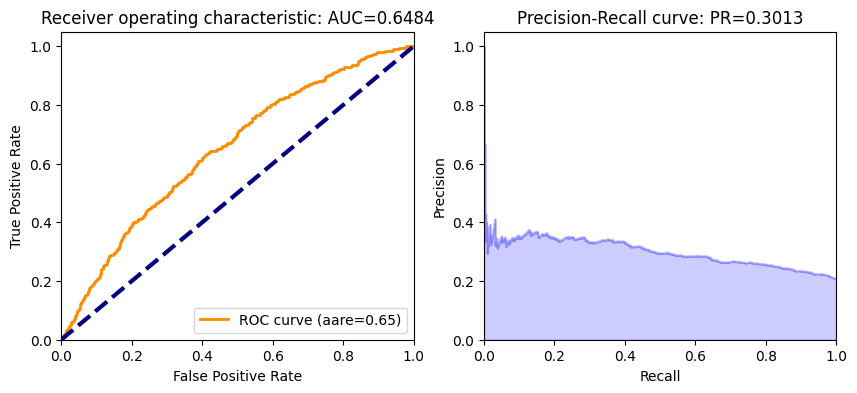

In [63]:
ROC_AUC(glm_v1,test_hex,'loan_default')

In [64]:
# Print the Coefficients table
coefs = glm_v1._model_json['output']['coefficients_table'].as_data_frame()
coefs = pd.DataFrame(coefs)
coefs.sort_values(by='standardized_coefficients',ascending=False)

,names,coefficients,standardized_coefficients
66,TD013,0.035970,0.180561
62,TD005,0.054836,0.149415
46,AP006.android,0.128661,0.128661
84,PA031,0.000921,0.091264
81,PA028,0.000515,0.054385
...,...,...,...
55,AP002,-0.160461,-0.075437
75,CR015,-0.100649,-0.110570
85,MB005,-0.036999,-0.136456
56,AP003,-0.214530,-0.257184


In [65]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()


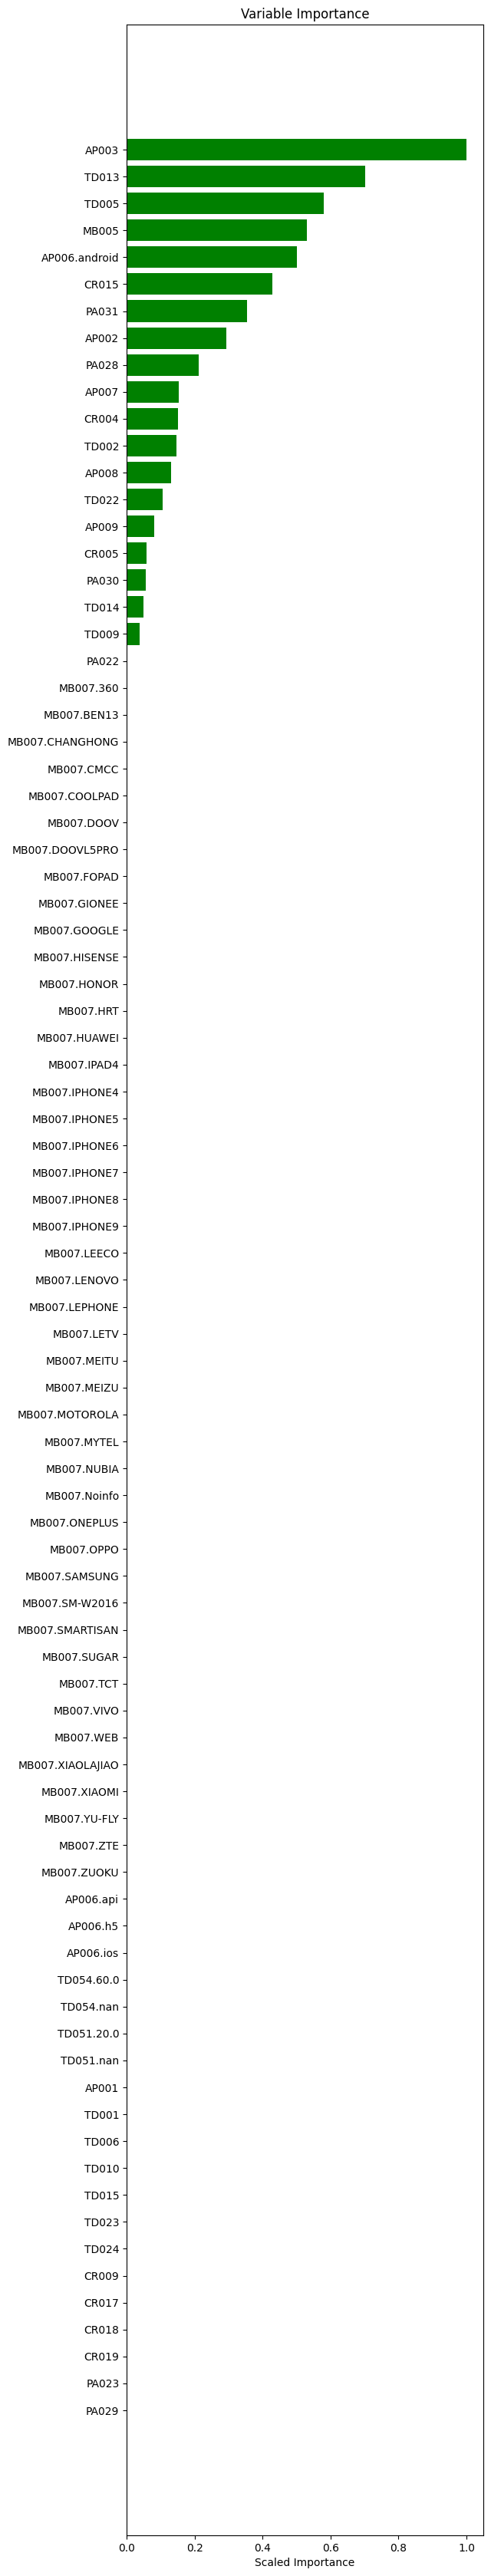

In [66]:
VarImp(glm_v1)

### Optimal Lambda

In [29]:
from h2o.grid.grid_search import H2OGridSearch


In [42]:
train_act = h2o.H2OFrame(train)
test_act = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
hyper_params = {'lambda': [1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0]}


In [44]:
glm_v2 = H2OGeneralizedLinearEstimator(family = 'binomial')


In [45]:
grid = H2OGridSearch(model = glm_v2, hyper_params = hyper_params,
                     search_criteria = {'strategy': "Cartesian"})

In [46]:
grid.train(x = predictors, y = target, training_frame = train_act)


glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [47]:
sorted_grid = grid.get_grid(sort_by = 'auc', decreasing = True)
print(sorted_grid)

       lambda  \
0       [0.0]   
1    [1.0E-5]   
2    [1.0E-4]   
3     [0.001]   
4      [0.01]   
5       [0.1]   
6       [1.0]   
7       [0.5]   

                                                               model_ids  \
0  Grid_GLM_Key_Frame__upload_877defafee2b87338694680fe7c44d88.hex_mo...   
1  Grid_GLM_Key_Frame__upload_877defafee2b87338694680fe7c44d88.hex_mo...   
2  Grid_GLM_Key_Frame__upload_877defafee2b87338694680fe7c44d88.hex_mo...   
3  Grid_GLM_Key_Frame__upload_877defafee2b87338694680fe7c44d88.hex_mo...   
4  Grid_GLM_Key_Frame__upload_877defafee2b87338694680fe7c44d88.hex_mo...   
5  Grid_GLM_Key_Frame__upload_877defafee2b87338694680fe7c44d88.hex_mo...   
6  Grid_GLM_Key_Frame__upload_877defafee2b87338694680fe7c44d88.hex_mo...   
7  Grid_GLM_Key_Frame__upload_877defafee2b87338694680fe7c44d88.hex_mo...   

                  auc  
0  0.8836926733403212  
1  0.6679001870930735  
2  0.6668471820256456  
3  0.6656712500992129  
4  0.6625275065275967  
5  0.606350751236

While the the AUC is highest at lambda = 0, it does not seem an approporiate value to use as when lambda = 0 regularization is disabled, and ordinary generalized liner models are fit. There would also be way too many variables to select from- creating noise for the model.
Instead, I choose to go with lambda = .01, where AUC is still very strong but we get still maintain some regularization over the model. 

### Now the code works fine with the small dataset, we can model with the entire dataset

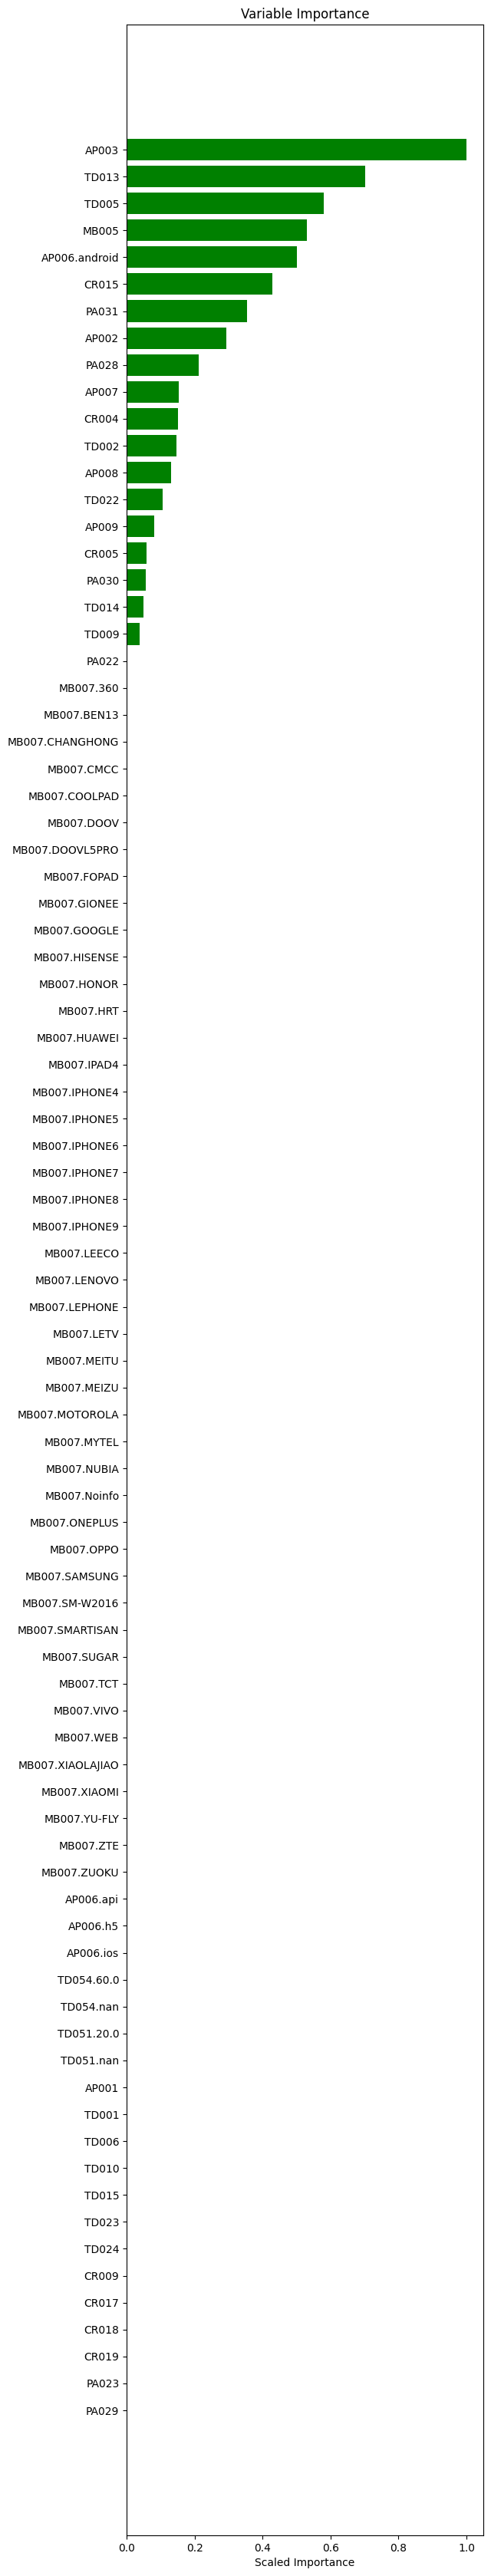

In [68]:
VarImp(glm_v1)

In [76]:
predictors = ['AP003','TD013','TD005','MB005','AP006','CR015','PA031','AP002','PA028','AP007','CR004','TD002']

Top 12 features selected

In [77]:
glm_v3 = H2OGeneralizedLinearEstimator(family= "binomial", lambda_ = 0.01) #, compute_p_values = True)
glm_v3.train(predictors,target,training_frame=train_act)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [78]:
glm_v3.predict(test_act)

glm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.840695,0.159305
0,0.830362,0.169638
0,0.8761,0.1239
1,0.803993,0.196007
1,0.581183,0.418817
0,0.85295,0.14705
1,0.486705,0.513295
1,0.775385,0.224615
1,0.751053,0.248947
0,0.87395,0.12605


In [79]:
predictions = glm_v3.predict(test_act)['p1']
test_scores = test_act['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,p1
0,0,0.159305
1,0,0.169638
2,0,0.123900
3,1,0.196007
4,0,0.418817


In [80]:
createGains(glm_v3)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,88,152,240,88,152,0.18,0.08,49.0,1.80,10.0,36.67
1,240,77,163,480,165,315,0.34,0.16,98.0,1.68,18.0,34.38
2,240,61,179,720,226,494,0.46,0.26,147.0,1.54,20.0,31.39
3,240,50,190,960,276,684,0.56,0.36,196.0,1.41,20.0,28.75
4,240,52,188,1200,328,872,0.67,0.46,245.0,1.34,21.0,27.33
5,240,46,194,1440,374,1066,0.76,0.56,294.0,1.27,20.0,25.97
6,240,40,200,1680,414,1266,0.84,0.66,343.0,1.21,18.0,24.64
7,240,33,207,1920,447,1473,0.91,0.77,392.0,1.14,14.0,23.28
8,240,25,215,2160,472,1688,0.96,0.88,441.0,1.07,8.0,21.85


glm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



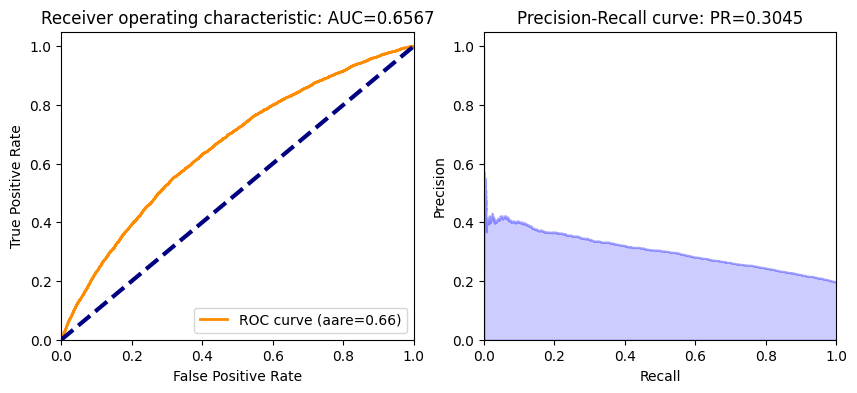

In [81]:
ROC_AUC(glm_v3,test_act,'loan_default')

Strong performance in AUC and PR, with lesser features

In [97]:
glm_v3.model_performance(test_act)


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.14947961032760354
RMSE: 0.3866259307490944
LogLoss: 0.4699400021840778
Null degrees of freedom: 23999
Residual degrees of freedom: 23988
Null deviance: 23649.019531807702
Residual deviance: 22557.120104835732
AIC: 22581.120104835732
AUC: 0.6566356916557139
AUCPR: 0.3042942842082782
Gini: 0.3132713833114278

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2043376178395013: 


,,0,1,Error,Rate
0,0,13103.0,6229.0,0.3222,(6229.0/19332.0)
1,1,2076.0,2592.0,0.4447,(2076.0/4668.0)
2,Total,15179.0,8821.0,0.346,(8305.0/24000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.204338,0.384313,219.0
1,max f2,0.124043,0.558408,334.0
2,max f0point5,0.242597,0.335755,170.0
3,max accuracy,0.547255,0.805583,17.0
4,max precision,0.655820,0.571429,5.0
5,max recall,0.060842,1.000000,394.0
6,max specificity,0.859377,0.999948,0.0
7,max absolute_mcc,0.205985,0.191789,217.0
8,max min_per_class_accuracy,0.193400,0.613111,234.0
9,max mean_per_class_accuracy,0.204338,0.616529,219.0



Gains/Lift Table: Avg response rate: 19.45 %, avg score: 19.36 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.435028,2.142245,2.142245,0.416667,0.496034,0.416667,0.496034,0.021422,0.021422,114.224507,114.224507,0.014181
1,2,0.02,0.394757,2.077978,2.110111,0.404167,0.412704,0.410417,0.454369,0.020780,0.042202,107.797772,111.011140,0.027563
2,3,0.03,0.368696,2.163668,2.127963,0.420833,0.380791,0.413889,0.429843,0.021637,0.063839,116.366752,112.796344,0.042010
3,4,0.04,0.349252,1.906598,2.072622,0.370833,0.358322,0.403125,0.411963,0.019066,0.082905,90.659811,107.262211,0.053265
4,5,0.05,0.334914,1.970865,2.052271,0.383333,0.342085,0.399167,0.397987,0.019709,0.102614,97.086547,105.227078,0.065318
5,6,0.10,0.290944,1.713796,1.883033,0.333333,0.310572,0.366250,0.354280,0.085690,0.188303,71.379606,88.303342,0.109626
6,7,0.15,0.263666,1.623822,1.796630,0.315833,0.276456,0.349444,0.328339,0.081191,0.269494,62.382177,79.662953,0.148348
7,8,0.20,0.245421,1.426735,1.704156,0.277500,0.254246,0.331458,0.309815,0.071337,0.340831,42.673522,70.415596,0.174837
8,9,0.30,0.217743,1.304627,1.570980,0.253750,0.230733,0.305556,0.283455,0.130463,0.471294,30.462725,57.097972,0.212655
9,10,0.40,0.197980,1.139674,1.463153,0.221667,0.207692,0.284583,0.264514,0.113967,0.585261,13.967438,46.315338,0.229995


# Run AutoML

In [83]:
from h2o.automl import H2OAutoML

In [84]:
aml_v1 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=1234)
aml_v1.train(predictors,target,training_frame=train_act)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [85]:
aml_v1.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210723_212526,0.147965,0.384662,0.147965,0.296029,0.269899
StackedEnsemble_BestOfFamily_AutoML_20210723_212526,0.148023,0.384737,0.148023,0.296221,0.269974
GLM_1_AutoML_20210723_212526,0.148729,0.385654,0.148729,0.30024,0.270144
DeepLearning_1_AutoML_20210723_212526,0.151637,0.389406,0.151637,0.279201,0.270925
GBM_2_AutoML_20210723_212526,0.152551,0.390578,0.152551,0.307823,0.273587
GBM_1_AutoML_20210723_212526,0.153224,0.391438,0.153224,0.308686,0.274248
GBM_grid__1_AutoML_20210723_212526_model_1,0.153412,0.391679,0.153412,0.308866,0.274476
GBM_3_AutoML_20210723_212526,0.153628,0.391954,0.153628,0.309112,0.274667
GBM_5_AutoML_20210723_212526,0.153707,0.392055,0.153707,0.30932,0.274735
XGBoost_3_AutoML_20210723_212526,0.154014,0.392447,0.154014,0.341927,0.284436


In [86]:
pred = aml_v1.predict(test_act)
pred.head()

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict
0.177807
0.191139
0.134092
0.219872
0.461156
0.145814
0.510344
0.24512
0.261492
0.161112


In [87]:
perf = aml_v1.leader.model_performance(test_act)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.14898696102799128
RMSE: 0.38598829130945317
MAE: 0.305442957254282
RMSLE: 0.2724494164045823
R^2: 0.04903811343292963
Mean Residual Deviance: 0.14898696102799128
Null degrees of freedom: 23999
Residual degrees of freedom: 23989
Null deviance: 3760.113673469694
Residual deviance: 3575.6870646717907
AIC: 22439.533911940835


Very similar results from the glm model with optimal lambda value and selected features, slightly stronger in RMSE and AIC

In [89]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(aml_v1)

stackedensemble prediction progress: |████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,91,149,240,91,149,0.19,0.08,49.0,1.86,11.0,37.92
1,240,70,170,480,161,319,0.33,0.17,98.0,1.64,16.0,33.54
2,240,62,178,720,223,497,0.46,0.26,147.0,1.52,20.0,30.97
3,240,59,181,960,282,678,0.58,0.35,196.0,1.44,23.0,29.38
4,240,53,187,1200,335,865,0.68,0.45,245.0,1.37,23.0,27.92
5,240,47,193,1440,382,1058,0.78,0.55,294.0,1.30,23.0,26.53
6,240,32,208,1680,414,1266,0.84,0.66,343.0,1.21,18.0,24.64
7,240,29,211,1920,443,1477,0.90,0.77,392.0,1.13,13.0,23.07
8,240,25,215,2160,468,1692,0.96,0.89,441.0,1.06,7.0,21.67


Cum lift is stronger than the glm model